# Import Data

In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

  0%|          | 0/141 [00:00<?, ?it/s]

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...
Finished loading INFO


100%|██████████| 141/141 [00:24<00:00,  5.86it/s]


In [5]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

In [67]:
angle_pk_scale = np.max(angle_power, axis=(0,1))/np.max(angles, axis=(0))
limb_pk_scale = np.max(limb_power, axis=(0,1))/np.max(limbs, axis=(0))
angles *= angle_pk_scale
limbs *= limb_pk_scale

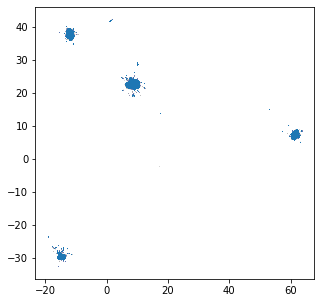

In [6]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
plt.show()

# Quick Overview

In [7]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

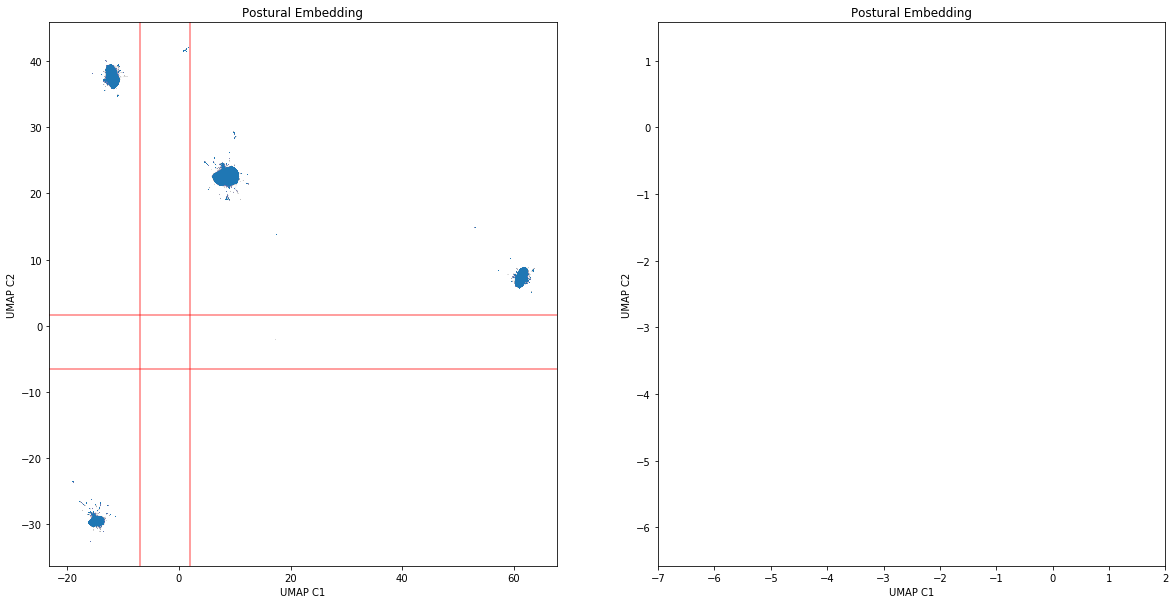

In [8]:
region_x_lim, region_y_lim = (-7,2), (-10,5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=2, alpha=0.006)
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

# Posture Snapshot (HDBSCAN)

In [9]:
import seaborn as sns
from sklearn.utils import shuffle

from utils.figure import plot_HDBSCAN
from cluster import HDBSCAN
%aimport cluster

In [14]:
labels, num_clusters, clusterer = HDBSCAN(all_postural_embed, min_cluster_size=3000, min_samples=20, 
                               cluster_selection_epsilon=0, cluster_selection_method="leaf", 
                               memory="memory")
color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

Frac Outlier: 0.14538564998947728
# Clusters: 20


100%|██████████| 20/20 [00:00<00:00, 9657.62it/s]


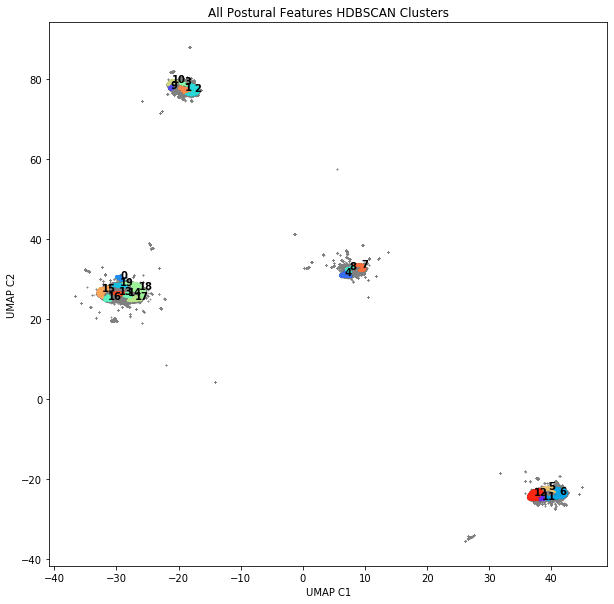

In [15]:
region_x_lim, region_y_lim = (-23,7), (-5,25)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_postural_embed, labels, color_palette, marker_size=0.2, alpha=0.2, toggle_numbering=True)
plt.show()
# plot_HDBSCAN(ax, all_postural_embed, labels, color_palette, marker_size=0.05, alpha=0.06, toggle_numbering=True, xlim=region_x_lim, ylim=region_y_lim)
# plt.show()

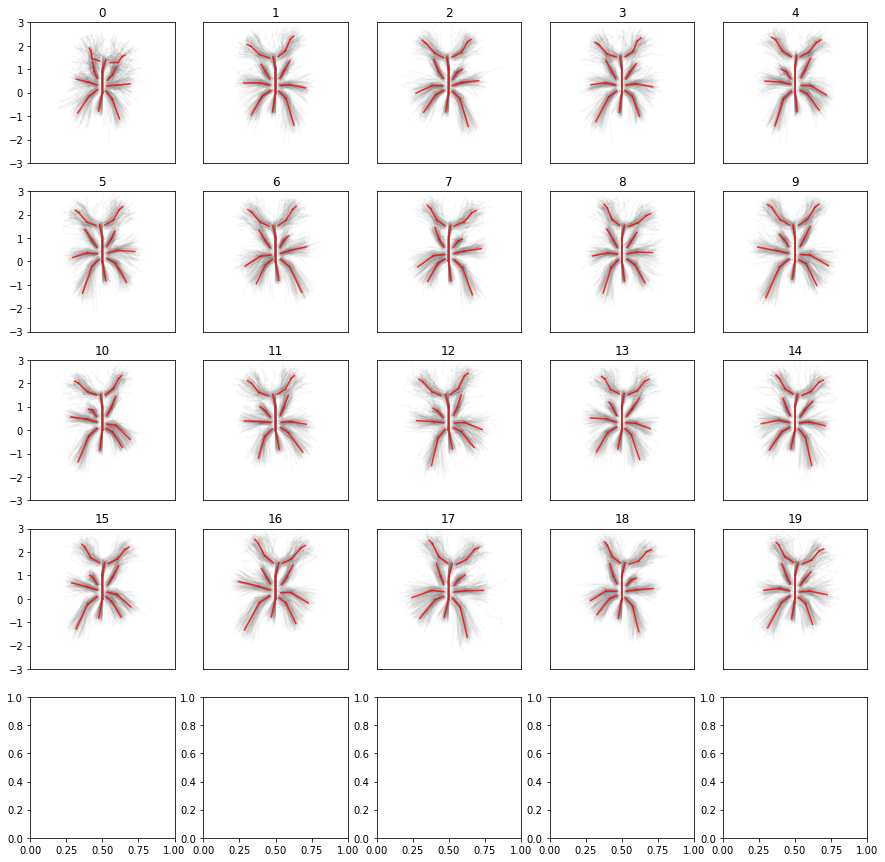

In [19]:
num_cluster = int(np.max(labels)+1)

num_columns = 5
num_rows = num_cluster//num_columns+1
fig, ax = plt.subplots(num_rows, num_columns, figsize=(3*num_rows,3*num_columns))

for i in tqdm(range(num_cluster)):
    idx = np.where(labels==i)[0]
    rand_idx = random.choices(idx, k=100)
    # sample skeleton (gray)
    for fr in rand_idx:
        for skeleton_i in skeleton:
            ax[i//num_columns,i%num_columns].plot(rot_bp[fr,skeleton_i,0], rot_bp[fr,skeleton_i,1], c='gray', alpha=0.05)
    # average skeleton (red)
    avg_rot_bp = np.mean(rot_bp[rand_idx,:,:], axis=0)
    for skeleton_i in skeleton:
        avg_rot_bp = np.mean(rot_bp[rand_idx,:,:], axis=0)
        ax[i//num_columns,i%num_columns].plot(avg_rot_bp[skeleton_i,0], avg_rot_bp[skeleton_i,1], c='red', alpha=0.8)
    # figure labels
    ax[i//num_columns,i%num_columns].set(title=f"{i}", xlim=(-3,3), ylim=(-3,3))
    if i%num_columns != 0:
        ax[i//num_columns,i%num_columns].yaxis.set_visible(False)
    if i//num_columns != num_rows:
        ax[i//num_columns,i%num_columns].xaxis.set_visible(False)

# Postural Snapshot (Watershed)

In [9]:
from cluster import Watershed
from sklearn.utils import shuffle
%load_ext autoreload
%autoreload 1
%aimport cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
num_fr, num_dim = all_postural_embed.shape
nan_fr, nan_dim = np.where(np.isnan(all_postural_embed))
np_unique_fr = np.unique(nan_fr)
good_fr = np.array([True]*num_fr)
good_fr[np_unique_fr] = False

good_all_embed = all_postural_embed[good_fr]

Creating 2D Grid System...(1/7)
Computing Gaussian Kernel...(2/7)
Finding Data Point Coordinates...(3/7)
Finding Local Max Basin Point...(4/7)
Creating Mask...(5/7)
Finding Watershed...(6/7)
Creating Watershed label...(7/7)
COMPLETE


/Users/donghur/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


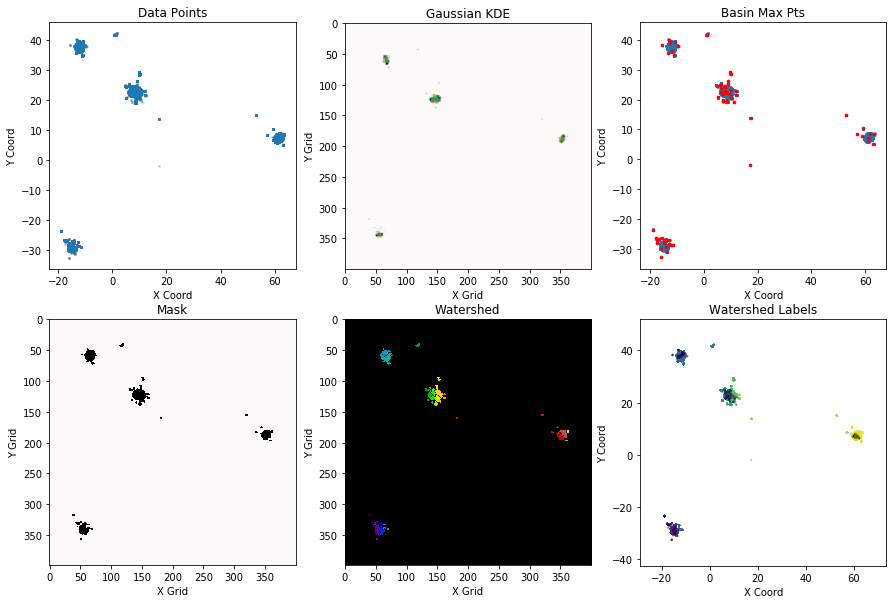

In [42]:
labels = Watershed(data=good_all_embed, grid_dim=400, bw_method=0.008, ROI_thresh=0.0001, 
                             grid_padding=10, verbose=True, fig_alpha=0.01, fig_s=2, 
                             watershed_line=True)


In [43]:
np.max(watershed_labels)

59

In [15]:
print(good_all_embed.shape)
shuffled_embed = shuffle(good_all_embed, n_samples=1000)
print(shuffled_embed)

array([[  6.93692684,  22.96998024],
       [-11.9328289 ,  37.59230042],
       [  8.24941254,  23.49242783],
       ...,
       [ 10.09459114,  22.11068344],
       [  7.83473969,  23.11467934],
       [  9.72674179,  22.48171425]])

Creating 2D Grid System...(1/7)


[Text(0, 0.5, 'Y Grid'),
 Text(0.5, 0, 'X Grid'),
 Text(0.5, 1.0, 'Gaussian KDE')]

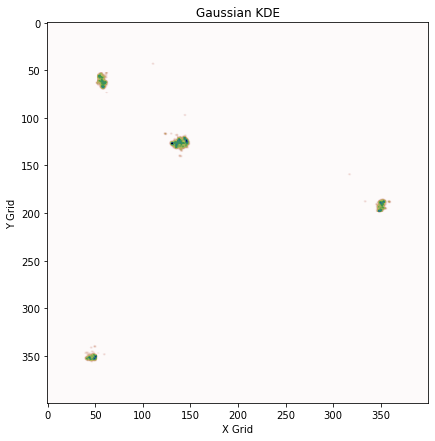

In [39]:
from scipy import stats

data = shuffled_embed
grid_padding=10
grid_dim=400

xmin, ymin = data.min(axis=0)-grid_padding
xmax, ymax = data.max(axis=0)+grid_padding

print("Creating 2D Grid System...(1/7)")
xgrid, ygrid = np.linspace(xmin,xmax,grid_dim), np.linspace(ymin,ymax,grid_dim)
grid_dim_j = complex(grid_dim)
X, Y = np.mgrid[xmin:xmax:grid_dim_j, ymin:ymax:grid_dim_j]
positions = np.vstack([X.ravel(), Y.ravel()])

kernel = stats.gaussian_kde(dataset=data.T, bw_method=0.008)
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
ax.set(title="Gaussian KDE", xlabel="X Grid", ylabel="Y Grid")

[Text(0, 0.5, 'Y Grid'),
 Text(0.5, 0, 'X Grid'),
 Text(0.5, 1.0, 'Gaussian KDE')]

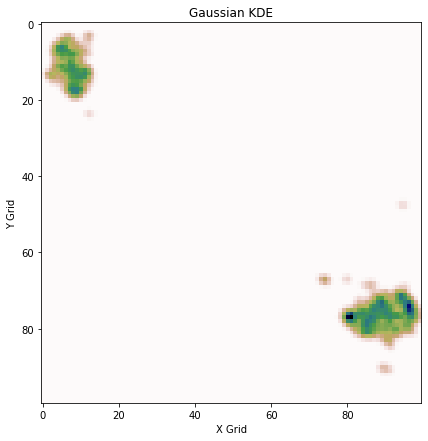

In [40]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(np.rot90(Z)[50:150, 50:150], cmap=plt.cm.gist_earth_r)
ax.set(title="Gaussian KDE", xlabel="X Grid", ylabel="Y Grid")

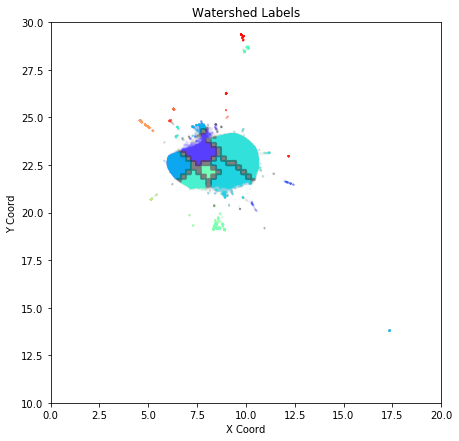

In [55]:
import seaborn as sns

xlim, ylim = [0,20], [10,30]

fig_alpha=0.01
fig_s=2


num_clusters = int(np.max(watershed_labels)+1)
outlier_pts = np.where(watershed_labels== -1)[0]
labeled_pts = np.where(watershed_labels!= -1)[0]

color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

# cmap: coloring
cluster_colors = np.array([color_palette[int(x)] if int(x) >= 0
                  else (0.5, 0.5, 0.5)
                  for x in watershed_labels])

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(good_all_embed[:,0], good_all_embed[:,1], alpha=fig_alpha, s=fig_s, c=cluster_colors)
ax.set(xlim=xlim, ylim=ylim)
ax.set(title="Watershed Labels", xlabel="X Coord", ylabel="Y Coord")
plt.show()


# Posture Analysis

In [74]:
labels.shape

(1872138,)

In [58]:
rot_bp.shape

(1872138, 30, 3)

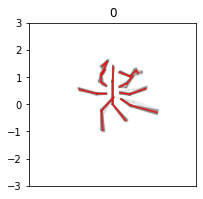

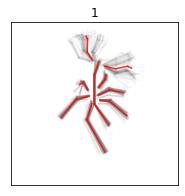

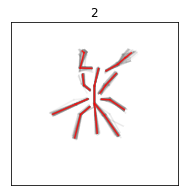

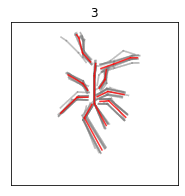

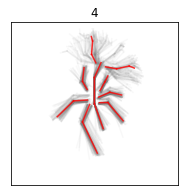

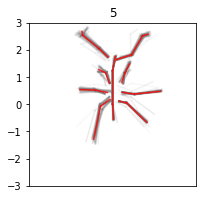

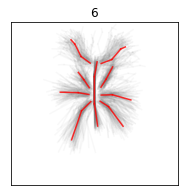

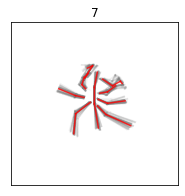

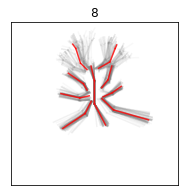

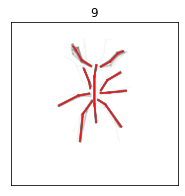

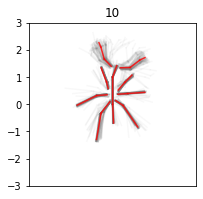

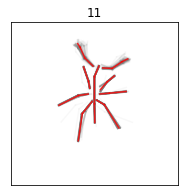

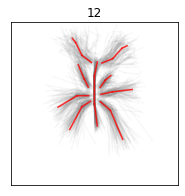

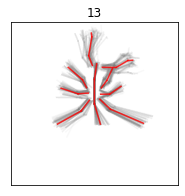

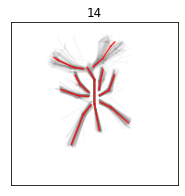

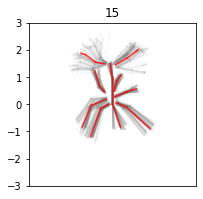

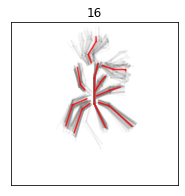

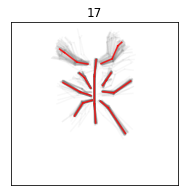

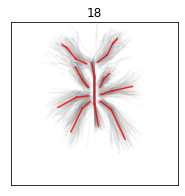

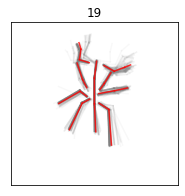

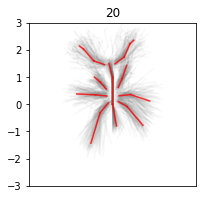

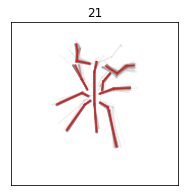

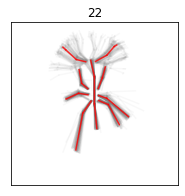

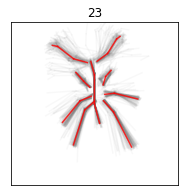

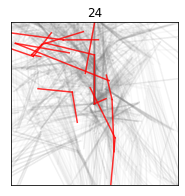

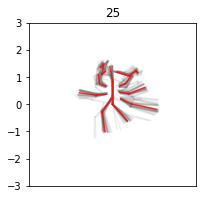

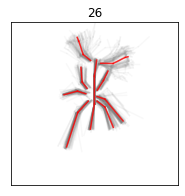

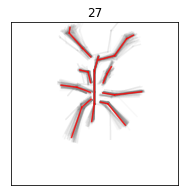

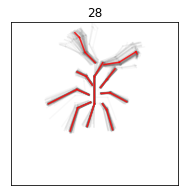

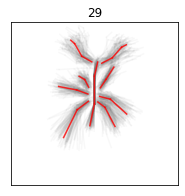

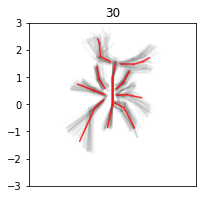

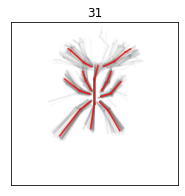

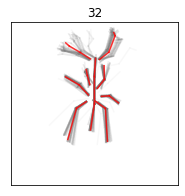

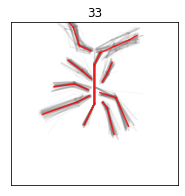

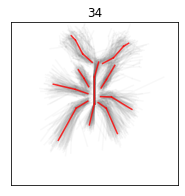

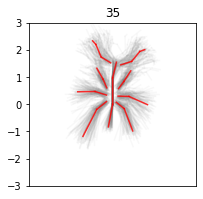

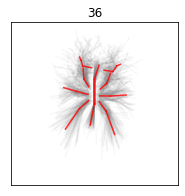

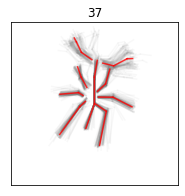

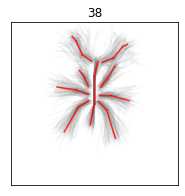

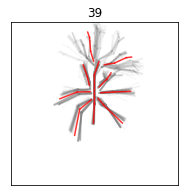

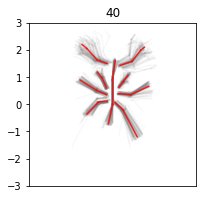

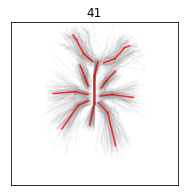

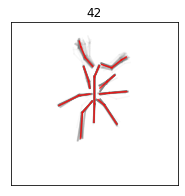

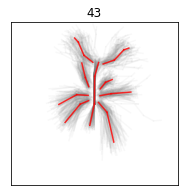

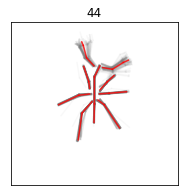

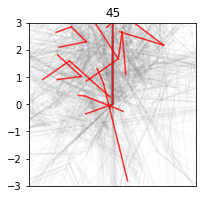

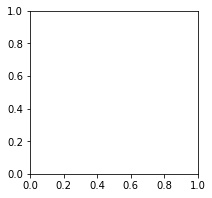

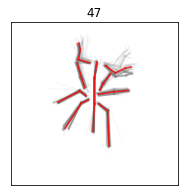

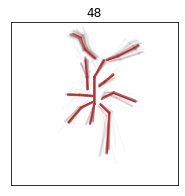

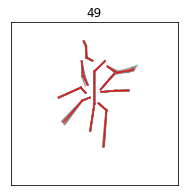

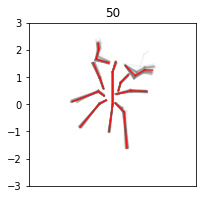

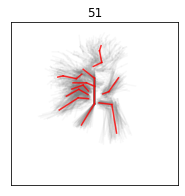

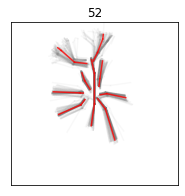

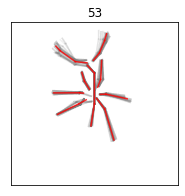

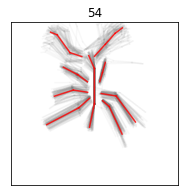

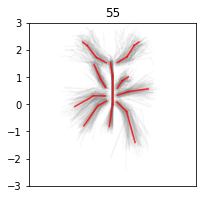

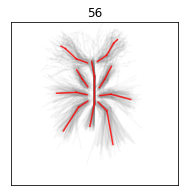

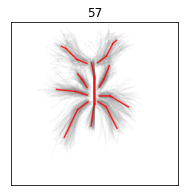

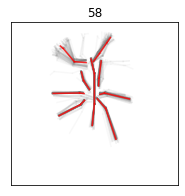

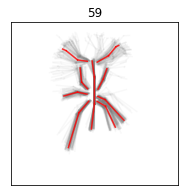

In [86]:
num_cluster = int(np.max(labels)+1)

num_columns = 5
num_rows = num_cluster//num_columns+1


for i in tqdm(range(num_cluster)):
    fig, ax = plt.subplots(figsize=(3,3))
    idx = np.where(labels==i)[0]
    if len(idx) != 0:
        rand_idx = random.choices(idx, k=100)
        # sample skeleton (gray)
        for fr in rand_idx:
            for skeleton_i in skeleton:
                ax.plot(rot_bp[fr,skeleton_i,0], rot_bp[fr,skeleton_i,1], c='gray', alpha=0.05)
        # average skeleton (red)
        avg_rot_bp = np.mean(rot_bp[rand_idx,:,:], axis=0)
        for skeleton_i in skeleton:
            avg_rot_bp = np.mean(rot_bp[rand_idx,:,:], axis=0)
            ax.plot(avg_rot_bp[skeleton_i,0], avg_rot_bp[skeleton_i,1], c='red', alpha=0.8)
        # figure labels
        ax.set(title=f"{i}", xlim=(-3,3), ylim=(-3,3))
        if i%num_columns != 0:
            ax.yaxis.set_visible(False)
        if i//num_columns != num_rows:
            ax.xaxis.set_visible(False)
        plt.show()

In [81]:
idx = np.where(labels==47)[0]

In [82]:
idx

array([  25149,  397421,  419129,  419130,  419132,  419133,  419134,
        419135,  419137,  419141,  419142,  419143,  419144,  419147,
        419148,  419156,  419157,  419159,  419161,  419162,  419163,
        419170,  419171,  419174,  419175,  419177,  419180,  419182,
        419193,  419195,  419215,  419383,  419392,  419395,  419397,
        419406,  419410,  419412,  419413,  419425,  419426,  419435,
        419437,  419438,  419440,  419441,  419442,  419443,  419444,
        419446,  419447,  419448,  419449,  419450,  419451,  419452,
        419454,  419458,  419459,  419461,  419462,  419463,  419464,
        419465,  419466,  419467,  419468,  419470,  419472,  419474,
        419476,  419477,  419481,  419482,  419483,  419485,  419486,
        419489,  419491,  419493,  419494,  419497,  419498,  419500,
        419503,  419505,  419506,  419507,  419509,  419510,  419511,
        419514,  419515,  419516,  419517,  419519,  419520,  419521,
        419522,  419